# Compute persistence and climatology scores for benchmark

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [23]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [6]:
z500 = xr.open_mfdataset(f'{DATADIR}*').z

In [7]:
z500

<xarray.DataArray 'z' (time: 350640, lat: 33, lon: 64)>
dask.array<shape=(350640, 33, 64), dtype=float32, chunksize=(8760, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

## Persistence

In [31]:
z500_validation = load_test_data(DATADIR)

In [32]:
z500_validation

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
dask.array<shape=(17520, 33, 64), dtype=float32, chunksize=(8760, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [40]:
def create_persistence_forecast(da, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    da_fc = da.isel(time=slice(0, -lead_time_h))
    return da_fc

In [41]:
fcs = []
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)})
for lead_time_h in lead_times:
    fcs.append(create_persistence_forecast(z500_validation, int(lead_time_h)))
fc_persistence = xr.concat(fcs, dim=lead_times)

In [42]:
fc_persistence.to_netcdf(f'{PREDDIR}/fc_persistence.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [43]:
rmses_persistence = evaluate_iterative_forecast(fc_persistence, z500_validation)

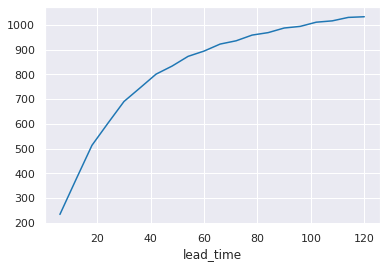

In [44]:
rmses_persistence.plot()

In [45]:
rmses_persistence.sel(lead_time=3*24)

<xarray.DataArray ()>
array(935.817115)
Coordinates:
    lead_time  int64 72

In [46]:
rmses_persistence.sel(lead_time=5*24)

<xarray.DataArray ()>
array(1033.052216)
Coordinates:
    lead_time  int64 120

## Climatology

In [100]:
def create_climatology_forecast(da_train):
    return da_train.mean('time')

In [101]:
z500_train = z500.sel(time=slice(None, '2016'))

In [102]:
fc = create_climatology_forecast(z500_train)

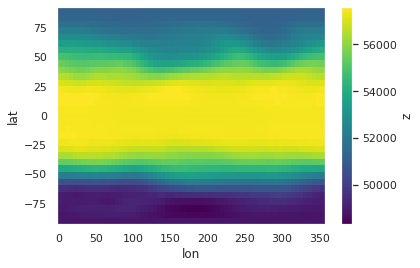

In [104]:
fc.plot();

In [106]:
compute_weighted_rmse(fc, z500_validation).values

array(1074.85560374)

In [121]:
def create_weekly_climatology_forecast(da_train, valid_time):
    da_train['week'] = da_train['time.week']
    weekly_averages = da_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [122]:
fc = create_weekly_climatology_forecast(z500_train, z500_validation.time)

In [123]:
fc

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
dask.array<shape=(17520, 33, 64), dtype=float32, chunksize=(1, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
    week     (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00

In [126]:
compute_weighted_rmse(fc, z500_validation).values

array(815.39207)

The End